In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error 


## Model Equations
$$\frac{dv}{dt} = gv(1-v) - \gamma v$$
$$g = g_0 (1 - (\frac{T_l - T_{opt}}{\beta})^2)$$
$$T_l = T_f - (1-v)a + GW$$

## Parameters
v = vegetation fraction <br>
a = difference between surface temperature of bare soil and forest $(^{\circ} C )$ <br>
$\beta$ = half-width of the growth versus temperature $(^{\circ} C )$ <br>
$g_0$ = maxium growth rate (yr$^{-1})$<br>
$\gamma$ = disturbance rate (yr$^{-1})$<br>
$T_{opt}$ = optimal temperature for plant growth $(^{\circ} C )$<br>
$T_f$ = temperature with total forest cover from pre-industrial conditions simulated in Cox et al. 2000 $(^{\circ} C )$
<br> <br>
$GW$ $(^{\circ} C )$ represents the global warming parameter. We can pick the warming rate and how many years we want that warming rate to occur. By varying $GW$ we can test how different levels of overshooting the threshold will impact the system. For this model I used a linear increase but for future work I could look at polynomial or exponential growth in global temperature. 


In [176]:
# Parameters
a = 5 #difference between surface temperature of bare soil and forest
b = 10 #half-width of the growth versus temperature
g_0 = 2 #maxium growth rate
gamma = 0.2 #disturbance rate
T_opt = 28 #optimal temperature for plant growth
T_f = 25 #temperature with total forest cover from pre-industrial conditions simulated in Cox et al

# Pre allocation
t_i = 0 
t_f = 700 # 500 years
dt = 0.01
timesteps = math.floor(t_f / dt) 
v_sol = np.zeros(timesteps)
g_sol = np.zeros(timesteps)
T_l_sol = np.zeros(timesteps)

# Initial Conditions
v_0 = 0.82 # taken from Cox et al. 2000
v_sol[0] = v_0 
T_l_sol[0] = T_f + (1-v_0)*a
g_sol[0] = g_0*(1- ((T_l_sol[0] - T_opt)/b)**2)

## Run model with linearly increasing global temperature to find threshold 

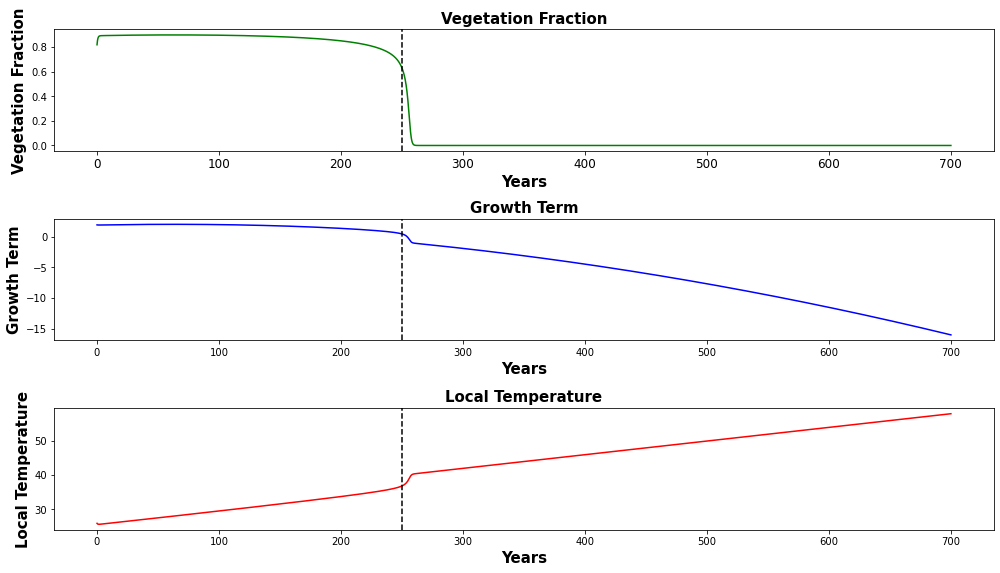

In [177]:
warming_rate = 0.0004 # Rate of warming: 1 degree every 25 years => 0.0004 degrees every timestep

def VegetationFraction(t, v):
    T_l = T_f + (1-v)*a + warming_rate*t
    g = g_0*(1- ((T_l - T_opt)/b)**2)
    dvdt = g*v*(1-v)-gamma*v
    return dvdt

# Runge Kutta 4
for i in range(timesteps - 1):
    k1_dvdt = VegetationFraction(i, v_sol[i]) * dt
    k2_dvdt = VegetationFraction(i+ 0.5*dt, v_sol[i] + 0.5*k1_dvdt)*dt
    k3_dvdt = VegetationFraction(i+ 0.5*dt, v_sol[i] + 0.5*k2_dvdt)*dt
    k4_dvdt = VegetationFraction(i+ dt, v_sol[i] + k3_dvdt)*dt
    
    v_sol[i+1] = v_sol[i] + (1/6)*(k1_dvdt + 2*k2_dvdt + 2*k3_dvdt + k4_dvdt)
    T_l_sol[i+1] = T_f + (1-v_sol[i+1])*a + warming_rate*i
    g_sol[i+1] = g_0*(1 - ((T_l_sol[i+1] - T_opt)/b)**2)

# Plot results
years = np.linspace(0, t_f, timesteps)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))


ax[0].plot(years, v_sol, 'g', label='Vegetation Fraction')
ax[0].set_title("Vegetation Fraction", fontsize="15", fontweight="bold")
ax[0].axvline(x = 250, color = 'black', linestyle='--')

ax[0].set_xlabel('Years', fontsize="15", fontweight="bold")
ax[0].set_ylabel('Vegetation Fraction', fontsize="15", fontweight="bold")
ax[0].tick_params(axis="x", labelsize=12) 

ax[1].plot(years, g_sol, 'b', label='Growth Term')
ax[1].set_title("Growth Term", fontsize="15", fontweight="bold")
ax[1].set_xlabel('Years', fontsize="15", fontweight="bold")
ax[1].set_ylabel('Growth Term', fontsize="15", fontweight="bold")
ax[1].axvline(x = 250, color = 'black', linestyle='--')



ax[2].plot(years, T_l_sol, 'r',  label='Local Temperature')
ax[2].set_title("Local Temperature", fontsize="15", fontweight="bold")
ax[2].set_xlabel('Years', fontsize="15", fontweight="bold")
ax[2].set_ylabel('Local Temperature', fontsize="15", fontweight="bold")
ax[2].axvline(x = 250, color = 'black', linestyle='--')
fig.tight_layout()

plt.show()

## Run model with linearly increasing GW overshooting threshold then stabilize at 1.5 degrees over pre-industrial conditions

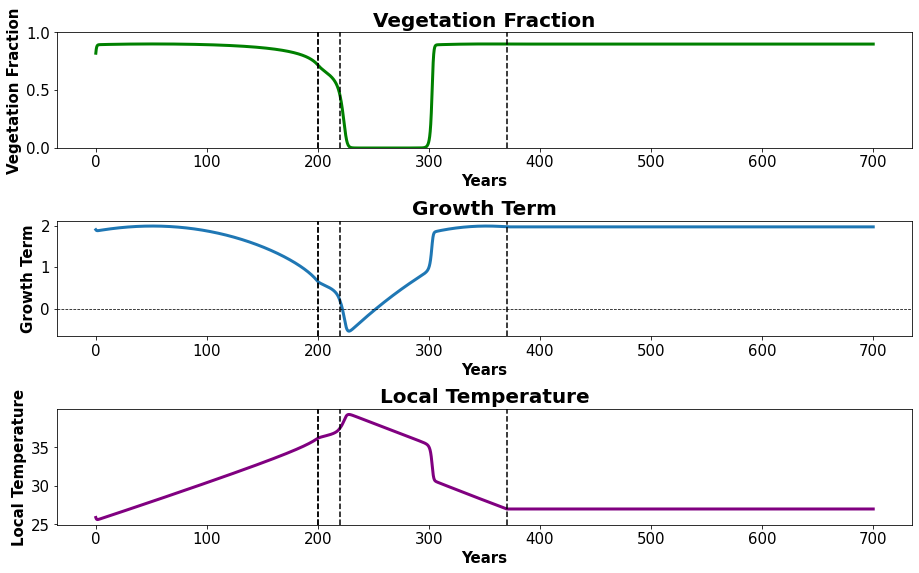

In [222]:
# We will simulate warming in 4 phases:
# PHASE 1 INITIAL WARMING warming at a rate of 4 degrees per 100 years for 100 years ie a 4 degree overshoot
# PHASE 2: OVERSHOOT PERIOD remain at 4 degrees above pre-industrial conditons for 15 years
# PHASE 3: COOLING cooling to return to 1.5 degrees above pre-industrial conditions in 150 years
# PHASE 4: STABILIZE WARMING remain at 1.5 degrees above pre-industrial conditions


#Set warming parameters
GW_years = 200. # number of years to reach overshoot
over_years = 20 # number of years to remain at the overshoot threshold
stop = math.floor(GW_years * (timesteps/t_f)) #time to stop temperature increase in terms of timesteps
over_stop = math.floor((over_years * (timesteps/t_f)) + stop)
over_deg = 9.8 # number of degrees to overshoot by
warming_rate = over_deg/stop
stable= 1.5 # assume global temperatures return to 1.5 over pre industrial conditions in 150 years
temp_diff = over_deg-1.5
cooling_years = math.floor(150 * (timesteps/t_f)) + over_stop
cooling_rate = temp_diff/(cooling_years-over_stop)
 
warming = np.zeros(timesteps)

# Model Function
def VegetationFraction_thresh(t, v):
    if (t <= stop):
        T_l = T_f + (1-v)*a + warming_rate*t
    elif (t > stop and t<= over_stop):
        T_l = T_f + (1-v)*a + over_deg
    elif (t > over_stop and t <= cooling_years):
        T_l = T_f + (1-v)*a + (over_deg - (t - over_stop)*cooling_rate)
    else:
        T_l = T_f + (1-v)*a + stable
    g = g_0*(1- ((T_l - T_opt)/b)**2)
    dvdt = g*v*(1-v)-gamma*v
    return dvdt


# Runge Kutta
for i in range(timesteps - 1):
    k1_dvdt = VegetationFraction_thresh(i, v_sol[i]) * dt
    k2_dvdt = VegetationFraction_thresh(i+ 0.5*dt, v_sol[i] + 0.5*k1_dvdt)*dt
    k3_dvdt = VegetationFraction_thresh(i+ 0.5*dt, v_sol[i] + 0.5*k2_dvdt)*dt
    k4_dvdt = VegetationFraction_thresh(i+ dt, v_sol[i] + k3_dvdt)*dt
    
    v_sol[i+1] = v_sol[i] + (1/6)*(k1_dvdt + 2*k2_dvdt + 2*k3_dvdt + k4_dvdt)
    if (i<=stop):
        T_l_sol[i+1] = T_f + (1-v_sol[i+1])*a + warming_rate*(i)
        warming[i+1] = warming_rate*i
    elif (i > stop and i<=over_stop ):
        T_l_sol[i+1] = T_f + (1-v_sol[i+1])*a + over_deg
        warming[i+1] = over_deg
    elif (i > over_stop and i <= cooling_years):
        T_l_sol[i+1] = T_f + (1-v_sol[i+1])*a + (over_deg - (i-over_stop)*cooling_rate)
        warming[i+1] = (over_deg- (i-over_stop)*cooling_rate)
    else:
        T_l_sol[i+1] = T_f + (1-v_sol[i+1])*a + stable
        warming[i+1] = 1.5
        
        
    g_sol[i+1] = g_0*(1- ((T_l_sol[i+1] - T_opt)/b)**2)


warming[-1] = 1.5 
warming[0] = 0
    
# Plot results
years = np.linspace(0, t_f, timesteps)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(13,8 ))
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='minor', labelsize=15)

ax[0].plot(years, v_sol, 'g', label='Vegetation Fraction', linewidth=3)
ax[0].set_title("Vegetation Fraction", fontsize=20, fontweight="bold")
ax[0].axvline(x = GW_years, color = 'black', linestyle='--')
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('Years', fontsize=15, fontweight="bold")
ax[0].set_ylabel('Vegetation Fraction', fontsize=15, fontweight="bold")
ax[0].axvline(x = GW_years, color = 'black', linestyle='--')
ax[0].axvline(x = cooling_years/100, color = 'black', linestyle='--')
ax[0].axvline(x = over_stop/100, color = 'black', linestyle='--')

ax[1].plot(years, g_sol, label='Growth Term', linewidth=3)
ax[1].set_title("Growth Term", fontsize=20, fontweight="bold")
ax[1].set_xlabel('Years', fontsize=15, fontweight="bold")
ax[1].set_ylabel('Growth Term', fontsize=15, fontweight="bold")
ax[1].axvline(x = GW_years, color = 'black', linestyle='--')
ax[1].axhline(y = 0, color = 'black', linestyle='--', linewidth=0.75)
ax[1].axvline(x = GW_years, color = 'black', linestyle='--')
ax[1].axvline(x = cooling_years/100, color = 'black', linestyle='--')
ax[1].axvline(x = over_stop/100, color = 'black', linestyle='--')
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='minor', labelsize=15)


ax[2].plot(years, T_l_sol, 'purple',  label='Local Temperature', linewidth=3)
ax[2].set_title("Local Temperature", fontsize=20, fontweight="bold")
ax[2].set_xlabel('Years', fontsize=15, fontweight="bold")
ax[2].set_ylabel('Local Temperature', fontsize=15, fontweight="bold")
ax[2].axvline(x = GW_years, color = 'black', linestyle='--')
ax[2].axvline(x = GW_years, color = 'black', linestyle='--')
ax[2].axvline(x = cooling_years/100, color = 'black', linestyle='--')
ax[2].axvline(x = over_stop/100, color = 'black', linestyle='--')
ax[2].tick_params(axis='both', which='major', labelsize=15)
ax[2].tick_params(axis='both', which='minor', labelsize=15)



#ax[3].plot(years, warming, 'red',   label='Global Temperature Above Pre-Industrial Conditions', linewidth=2)
#ax[3].set_title("Global Temperature Above Pre-Industrial Conditions", fontsize=20, fontweight="bold")
#ax[3].set_xlabel('Years', fontsize=15, fontweight="bold")
#ax[3].set_ylabel('Global Temperature', fontsize=15, fontweight="bold")
#ax[3].axvline(x = GW_years, color = 'black', linestyle='--')
#ax[3].axvline(x = cooling_years/100, color = 'black', linestyle='--')
#ax[3].axvline(x = over_stop/100, color = 'black', linestyle='--')
fig.tight_layout()
plt.show()






## Pre built solver implementation with different warming rates

<Figure size 432x288 with 0 Axes>

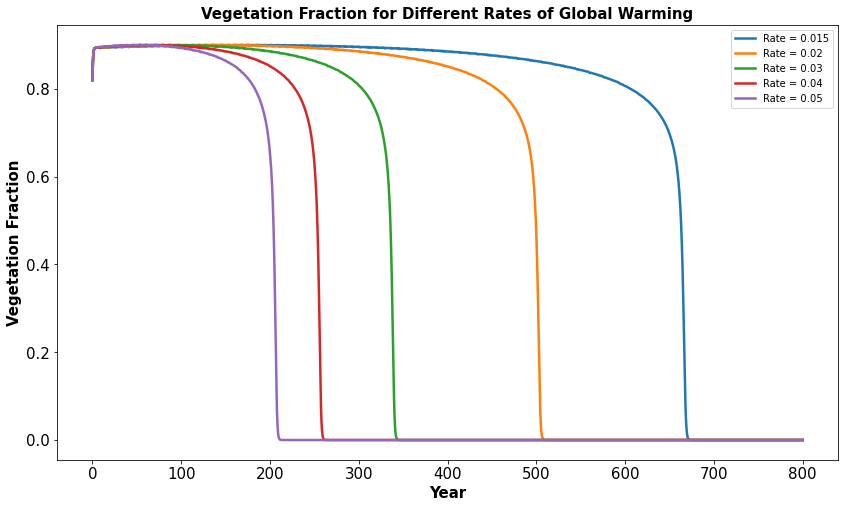

In [16]:
def VegetationFractionPB(t, v):
    T_l = T_f + (1-v)*a + rate*t
    g = g_0*(1- ((T_l - T_opt)/b)**2)
    dvdt = g*v*(1-v)-gamma*v
    return dvdt

rates = [0.015, 0.02, 0.03, 0.04, 0.05]
plt.figure()
plt.figure(figsize=(14, 8))
for i in range(5):
    rate = rates[i]
    sol = solve_ivp(VegetationFractionPB, (0, 800), [0.82], method='RK45',t_eval=np.linspace(0,800,80000))
    plt.plot(sol.t, sol.y[0], label = 'Rate = ' + str(rates[i]), linewidth = 2.5)
plt.legend()
plt.xlabel("Year", fontsize = 15, fontweight= 'bold')
plt.ylabel("Vegetation Fraction", fontsize = 15, fontweight= 'bold')
plt.title("Vegetation Fraction for Different Rates of Global Warming", fontsize = 15, fontweight= 'bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.show()


## Pre-built solver comparison

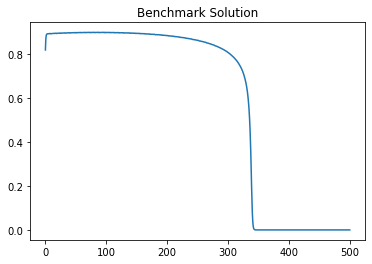

In [152]:
#We will compare the pre-built solver to the manual implementation for a warming rate of 3 degrees per year

#Pre-built solution benchmark
# dt = 0.0001
rate = 0.03
sol_bench = solve_ivp(VegetationFractionPB, (0, 500), [0.82], method='RK45',t_eval=np.linspace(0,500,5000000)) 
y_bench = sol_bench.y[0]
t_bench = sol_bench.t

plt.figure()
plt.plot(t_bench,y_bench)
plt.title("Benchmark Solution")
plt.show()



In [157]:
#We will compare the pre-built benchmark to the manual implementation for a warming rate of 3 degrees per year

#manual

dts = [0.001, 0.01, 0.1, 1] # dts to compare to benchmark
errors = np.zeros(len(dts))

for j in range(len(dts)):
    dt = dts[j]
    warming_rate = 0.03*dt #scale warming rate based on dt
    timesteps = math.floor(500/dt)
    v_sol = np.zeros(timesteps)
    
    v_sol[0]=0.82 
    
    #solve manually using given dt
    for i in range(timesteps - 1):
        k1_dvdt = VegetationFraction(i, v_sol[i]) * dt
        k2_dvdt = VegetationFraction(i+ 0.5*dt, v_sol[i] + 0.5*k1_dvdt)*dt
        k3_dvdt = VegetationFraction(i+ 0.5*dt, v_sol[i] + 0.5*k2_dvdt)*dt
        k4_dvdt = VegetationFraction(i+ dt, v_sol[i] + k3_dvdt)*dt
    
        v_sol[i+1] = v_sol[i] + (1/6)*(k1_dvdt + 2*k2_dvdt + 2*k3_dvdt + k4_dvdt)
    

    #compare to benchmark error
    if (dt == 0.001):
        v_sol_001 = np.zeros(timesteps)
        v_sol_001 = v_sol
    step = math.floor(5000000/len(v_sol))

    y_temp = y_bench[0:5000000:step]
    errors[j] = mean_squared_error(y_temp, v_sol)
    print(errors[j])



1.3358057920609507e-07
1.1588256474140934e-07
1.4104511275160096e-07
2.3013540903945198e-07


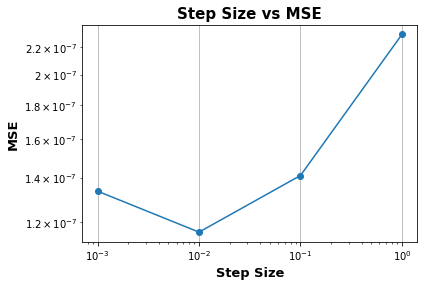

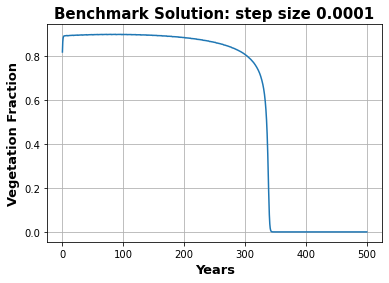

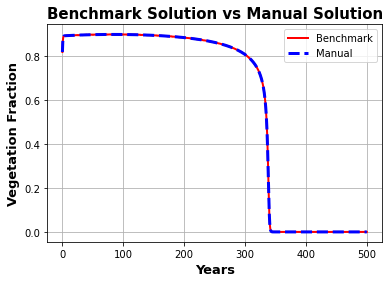

In [174]:
plt.figure()
plt.loglog(dts, errors, 'o-')
plt.title("Step Size vs MSE", fontsize = 15, fontweight = 'bold')
plt.xlabel("Step Size", fontsize = 13, fontweight = 'bold')
plt.ylabel("MSE", fontsize = 13, fontweight = 'bold')
plt.grid()
plt.show()

plt.figure()
plt.plot(t_bench,y_bench)
plt.title("Benchmark Solution: step size 0.0001", fontsize = 15, fontweight = 'bold')
plt.xlabel("Years", fontsize = 13, fontweight = 'bold')
plt.ylabel("Vegetation Fraction", fontsize = 13, fontweight = 'bold')
plt.grid()
plt.show()


plt.figure()
plt.plot(t_bench,y_bench, color = 'red', linewidth = '2', label = 'Benchmark')
plt.title("Benchmark Solution vs Manual Solution", fontsize = 15, fontweight = 'bold')
plt.xlabel("Years", fontsize = 13, fontweight = 'bold')
plt.ylabel("Vegetation Fraction", fontsize = 13, fontweight = 'bold')
years = np.linspace(0,500, len(v_sol_001))
plt.plot(years, v_sol_001, linestyle = "--", linewidth = '3', label = 'Manual', color = 'blue')
plt.grid()
plt.legend()
plt.show()